In [1]:
import firebase_admin
from firebase_admin import credentials, firestore

cred = credentials.Certificate("serviceAccountKey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()



/Users/lawrencefulton/PycharmProjects/test1/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
chat = db.collection("chat").get()


In [38]:
import  pandas as pd
import json

chat_list = []
for doc in chat:
    chat_list.append(doc.to_dict())
chat_df = pd.DataFrame(chat_list)
chat_df.head()




,0,questionTitle,1
0,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",Erbschaftssteuer,"[{'questionID': 'p1', 'answerValue': 2}, {'que..."
1,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",Erbschaftssteuer,"[{'questionID': 'p1', 'answerValue': 3}, {'que..."
2,"[{'questionID': 'p1', 'answerValue': 5}, {'que...",AfD-Verbot,"[{'questionID': 'p1', 'answerValue': 5}, {'que..."
3,"[{'questionID': 'p1', 'answerValue': 1}, {'que...",Tempolimit,"[{'questionID': 'p1', 'answerValue': 2}, {'que..."
4,"[{'questionID': 'p1', 'answerValue': 2}, {'que...",Erbschaftssteuer,"[{'questionID': 'p1', 'answerValue': 5}, {'que..."


In [49]:
#remove columns with empty values
chat_df = chat_df.dropna(subset=['1'])

# sace the data to a csv file
chat_df.to_csv("chat.csv", index=False)

In [51]:
def flatten_json_column(json_list, prefix):
    # Initialize an empty dictionary
    flattened_dict = {}

    # Iterate over each item in the list
    for item in json_list:
        # Extract questionID and answerValue and add to the dictionary with prefix
        flattened_dict[f"{prefix}_{item['questionID']}"] = item['answerValue']

    # Convert the dictionary to a pd.Series and return it
    return pd.Series(flattened_dict)

In [52]:
flattened_0 = chat_df['0'].apply(flatten_json_column, prefix='0')
flattened_1 = chat_df['1'].apply(flatten_json_column, prefix='1')

# # Concatenate the flattened columns with the original DataFrame
df_flattened = pd.concat([chat_df.drop(columns=['0', '1']), flattened_0, flattened_1], axis=1)
df_flattened.head()

,questionTitle,0_p1,0_p2,0_p3,0_p4,0_p5,0_p6,0_p7,0_q0,0_p8,1_p1,1_p2,1_p3,1_p4,1_p5,1_p6,1_p7,1_q0,1_p8
0,Erbschaftssteuer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,NaN
1,Erbschaftssteuer,1.0,2.0,4.0,1.0,4.0,NaN,NaN,2.0,NaN,3.0,3.0,2.0,4.0,3.0,NaN,NaN,1.0,NaN
2,AfD-Verbot,5.0,3.0,1.0,1.0,2.0,3.0,2.0,5.0,NaN,5.0,5.0,1.0,1.0,1.0,4.0,4.0,5.0,NaN
3,Tempolimit,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,2.0,4.0,2.0,3.0,2.0,3.0,2.0,2.0,NaN
4,Erbschaftssteuer,2.0,3.0,3.0,4.0,3.0,3.0,4.0,1.0,NaN,5.0,2.0,3.0,4.0,1.0,0.0,0.0,1.0,NaN


In [54]:
import matplotlib.pyplot as plt

In [77]:
def plot_all_distributions(df):
    # Get all unique question titles
    question_titles = df['questionTitle'].unique()

    # Loop through each unique question title
    for question_title in question_titles:
        # Filter the DataFrame for the selected question title
        filtered_df = df.where(df['questionTitle'] == question_title)

        # Concatenate relevant columns
        responses = pd.concat([filtered_df['0_p1'], filtered_df['1_p1']])

        # Clean up the data
        responses = responses.dropna().astype(int)

        # Sort and count values
        sorted_responses = responses.sort_values()

        # Plot the distribution
        sorted_responses.value_counts().sort_index().plot(kind='bar')

        # Add a title dynamically
        plt.title(f'Verteilung bei der {question_title} Frage')

        # Show the plot for each question title
        plt.show()

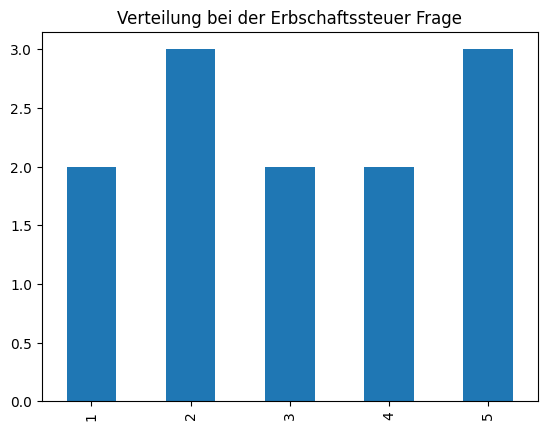

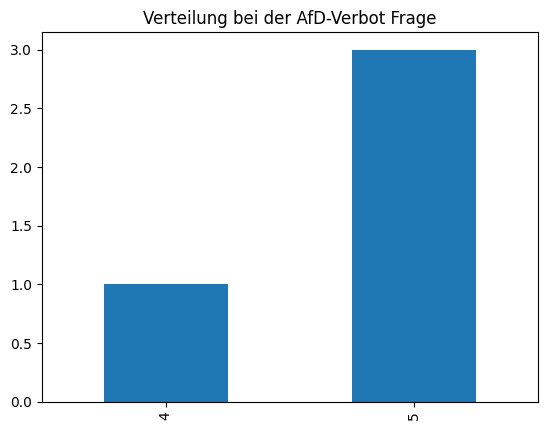

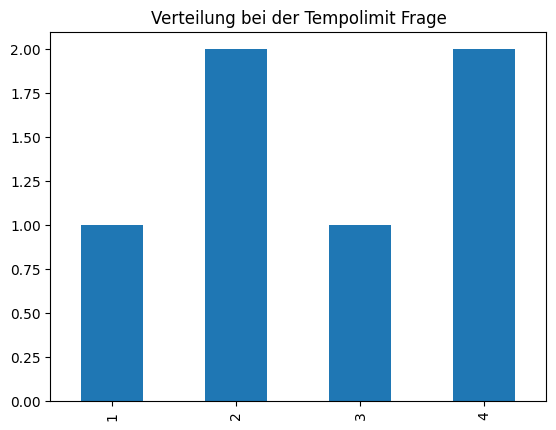

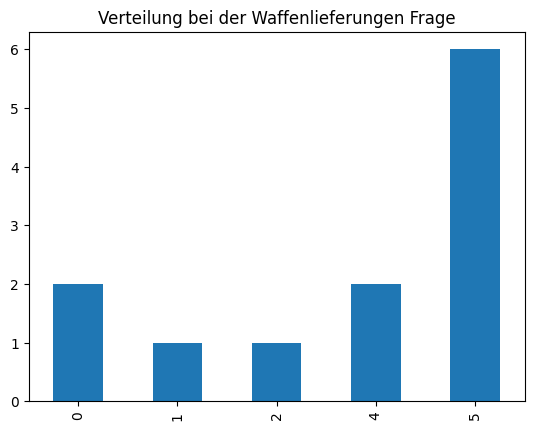

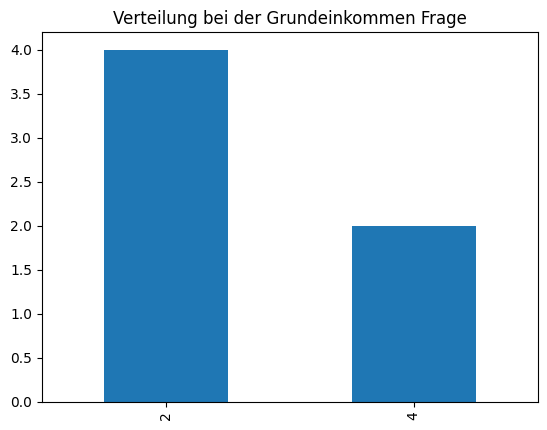

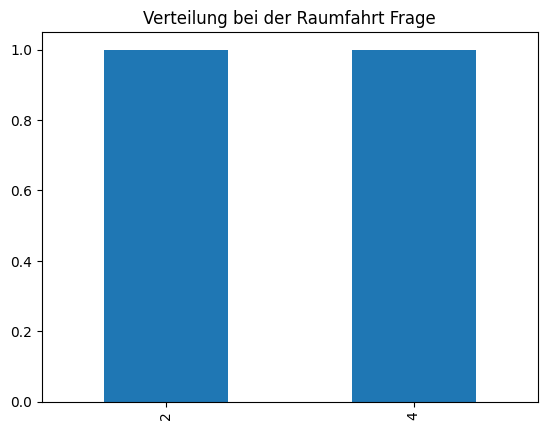

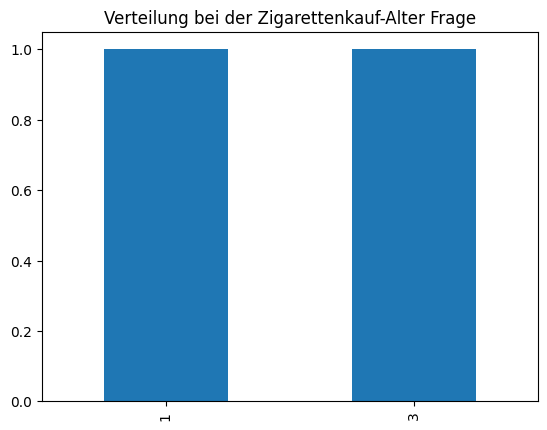

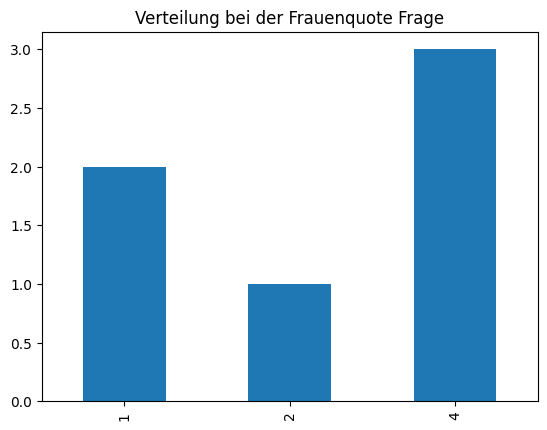

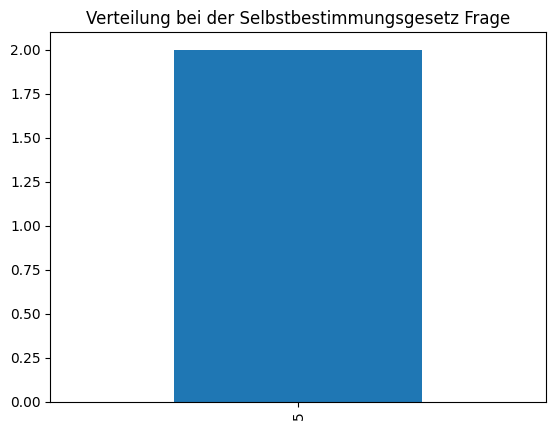

In [78]:
plot_all_distributions(df_flattened)